<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por palabras

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


Se utilizará el corpus de las canciones de Michael Jackson, cuya cantidad de documentos corresponden a 9484.

In [ ]:
pip install tensorflow

In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Como ejemplo se utilizará como corpus un dataset canciones de bandas de habla inglés.

In [ ]:
# Descargamos la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

--2024-10-07 12:58:48--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2024-10-07 12:58:48--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2024-10-07 12:58:48--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.

In [ ]:
# Armamos el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/michael-jackson.txt', sep='/n', header=None)
df.head()

<ipython-input-6-8ec73369ecf3>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/michael-jackson.txt', sep='/n', header=None)


,0
0,[Spoken Intro:]
1,You ever want something
2,that you know you shouldn't have
3,"The more you know you shouldn't have it,"
4,The more you want it


Consideraremos que cada secuencia para este dataset es un verso.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los versos del dataset y ses explorará la cantidad de términos presentes.



In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 9484


### Elegir el tamaño del contexto

In [ ]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [ ]:
# cada verso lo guardamos en una lista
text = list(df.loc[:,0])
text

['[Spoken Intro:]',
 'You ever want something',
 "that you know you shouldn't have",
 "The more you know you shouldn't have it,",
 'The more you want it',
 'And then one day you get it,',
 "It's so good too",
 "But it's just like my girl",
 "When she's around me",
 'I just feel so good, so good',
 'But right now I just feel cold, so cold',
 'Right down to my bones',
 "'Cause ooh...",
 "Ain't no sunshine when she's gone",
 "It's not warm when she's away",
 "Ain't no sunshine when she's gone",
 "And she's always gone too long",
 'Anytime she goes away',
 "Wonder this time where she's gone",
 "Wonder if she's gone to stay",
 "Ain't no sunshine when she's gone",
 "And this house just ain't no home",
 'Anytime she goes away',
 'I know, I know, I know, I know,',
 'I know, know, know, know, know,',
 'I know, I know,',
 'Hey I ought to leave',
 'I ought to leave her alone',
 "Ain't no sunshine when she's gone",
 "Ain't no sunshine when she's gone",
 'Only darkness every day',
 "Ain't no sunshi

In [ ]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [ ]:
text[0]

'[Spoken Intro:]'

In [ ]:
segmented_sentences[0]

['spoken', 'intro']

In [ ]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([5.950e+02, 6.180e+02, 1.179e+03, 1.605e+03, 1.509e+03, 1.404e+03,
        9.170e+02, 6.920e+02, 3.830e+02, 2.540e+02, 1.570e+02, 6.200e+01,
        6.300e+01, 2.300e+01, 1.000e+01, 7.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 4.000e+00]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  ]),
 <BarContainer object of 20 artists>)

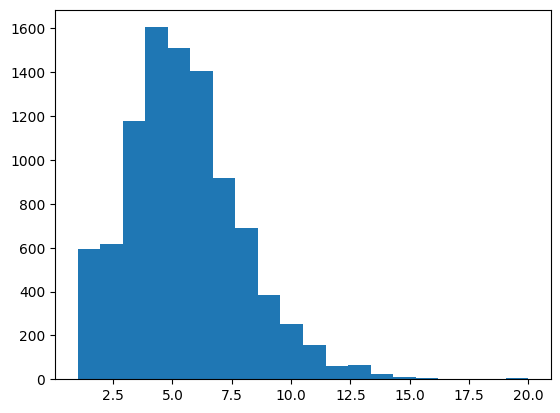

In [ ]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [ ]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 8


###  Tokenizar

In [ ]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [ ]:
tokenized_sentences[0]

[680, 1001]

In [ ]:
segmented_sentences[0]

['spoken', 'intro']

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [ ]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

\Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

Por ejemplo, si tenemos el texto *La bella y graciosa moza marchóse a lavar la ropa* y nuestro contexto es de 5 palabras, tendremos:

- *La bella y graciosa moza*
- *bella y graciosa moza marchóse*
- *y graciosa moza marchóse a*
- *graciosa moza marchóse a lavar*
- *moza marchóse a lavar la*
- *marchóse a lavar la ropa*

In [ ]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [ ]:
len(tok_sent)

8645

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [ ]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [ ]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [ ]:
train_seqs.shape

(39554, 9)

In [ ]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [ ]:
y.shape

(39554, 8)

In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'the',
 3: 'i',
 4: 'me',
 5: 'to',
 6: 'and',
 7: 'it',
 8: 'a',
 9: 'my',
 10: 'in',
 11: 'love',
 12: 'your',
 13: "don't",
 14: 'is',
 15: 'of',
 16: 'that',
 17: 'on',
 18: 'just',
 19: 'be',
 20: 'for',
 21: 'all',
 22: 'baby',
 23: 'so',
 24: 'know',
 25: 'no',
 26: "you're",
 27: "i'm",
 28: 'do',
 29: 'get',
 30: 'got',
 31: 'what',
 32: 'girl',
 33: 'she',
 34: 'are',
 35: 'with',
 36: 'yeah',
 37: 'bad',
 38: 'make',
 39: "it's",
 40: 'we',
 41: 'like',
 42: 'can',
 43: 'but',
 44: 'if',
 45: 'really',
 46: 'about',
 47: 'when',
 48: "can't",
 49: 'this',
 50: 'let',
 51: 'oh',
 52: 'wanna',
 53: 'too',
 54: 'he',
 55: 'world',
 56: 'stop',
 57: 'now',
 58: 'take',
 59: 'there',
 60: 'her',
 61: 'give',
 62: 'time',
 63: 'go',
 64: 'see',
 65: 'come',
 66: 'keep',
 67: 'how',
 68: 'will',
 69: 'why',
 70: 'one',
 71: "ain't",
 72: 'way',
 73: 'they',
 74: 'have',
 75: 'life',
 76: 'right',
 77: 'away',
 78: 'chorus',
 79: 'feel',
 80: 'not',
 81: 'around',
 82

In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

3273

In [ ]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'you': 1, 'the': 2, 'i': 3, 'me': 4, 'to': 5, 'and': 6, 'it': 7, 'a': 8, 'my': 9, 'in': 10, 'love': 11, 'your': 12, "don't": 13, 'is': 14, 'of': 15, 'that': 16, 'on': 17, 'just': 18, 'be': 19, 'for': 20, 'all': 21, 'baby': 22, 'so': 23, 'know': 24, 'no': 25, "you're": 26, "i'm": 27, 'do': 28, 'get': 29, 'got': 30, 'what': 31, 'girl': 32, 'she': 33, 'are': 34, 'with': 35, 'yeah': 36, 'bad': 37, 'make': 38, "it's": 39, 'we': 40, 'like': 41, 'can': 42, 'but': 43, 'if': 44, 'really': 45, 'about': 46, 'when': 47, "can't": 48, 'this': 49, 'let': 50, 'oh': 51, 'wanna': 52, 'too': 53, 'he': 54, 'world': 55, 'stop': 56, 'now': 57, 'take': 58, 'there': 59, 'her': 60, 'give': 61, 'time': 62, 'go': 63, 'see': 64, 'come': 65, 'keep': 66, 'how': 67, 'will': 68, 'why': 69, 'one': 70, "ain't": 71, 'way': 72, 'they': 73, 'have': 74, 'life': 75, 'right': 76, 'away': 77, 'chorus': 78, 'feel': 79, 'not': 80, 'around': 81, 'gonna': 82, 'say': 83, 'up': 84, 'down': 85, "she's": 86, 'was': 87, 'out': 88, 't

In [ ]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'spoken': 8, 'intro': 4, 'you': 2166, 'something': 24, 'ever': 46, 'want': 112, 'know': 239, 'have': 136, 'that': 401, "shouldn't": 4, 'it': 826, 'the': 1560, 'more': 39, 'then': 98, 'get': 262, 'one': 137, 'and': 909, 'day': 112, "it's": 214, 'too': 152, 'so': 302, 'good': 50, 'like': 215, 'but': 195, 'girl': 237, 'my': 695, 'just': 395, 'around': 109, "she's": 119, 'when': 179, 'me': 1140, 'i': 1219, 'feel': 128, 'right': 136, 'cold': 38, 'now': 160, 'bones': 2, 'down': 125, 'to': 1032, "'cause": 110, 'ooh': 56, 'sunshine': 14, "ain't": 139, 'gone': 64, 'no': 251, 'not': 131, 'away': 134, 'warm': 15, 'always': 61, 'long': 33, 'she': 236, 'goes': 17, 'anytime': 5, 'this': 181, 'where': 58, 'wonder': 10, 'time': 163, 'if': 192, 'stay': 51, 'home': 25, 'house': 5, 'ought': 3, 'leave': 72, 'hey': 23, 'her': 154, 'alone': 105, 'every': 76, 'only': 46, 'darkness': 6, 'be': 371, 'stayed': 5, 'can': 199, 'did': 62, 'was': 109, 'your': 473, 'mind': 43, 'thing': 45,


### Definir el modelo

Modelo 1: guardado como "Model"

In [ ]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True))
# model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, None, 50)            │         163,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, None, 100)           │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, None, 100)           │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, None, 3274)          │         330,674 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 635,174 (2.42 MB)

 Trainable params: 635,174 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("model_MJ_3.keras")
          print("Saved model 3!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [ ]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

Epoch 1/20
618/619 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 4.4733
 mean perplexity: 2694.6378831211564 

Saved model !
619/619 ━━━━━━━━━━━━━━━━━━━━ 110s 171ms/step - loss: 4.4710
Epoch 2/20
618/619 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 3.4025
 mean perplexity: 3315.6472691159875 

619/619 ━━━━━━━━━━━━━━━━━━━━ 147s 179ms/step - loss: 3.4024
Epoch 3/20
618/619 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 3.2984
 mean perplexity: 3410.9282798049635 

619/619 ━━━━━━━━━━━━━━━━━━━━ 142s 179ms/step - loss: 3.2983
Epoch 4/20
618/619 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.1905
 mean perplexity: 2832.650763236719 

619/619 ━━━━━━━━━━━━━━━━━━━━ 131s 161ms/step - loss: 3.1905
Epoch 5/20
619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 3.1238
 mean perplexity: 2851.746575217557 

619/619 ━━━━━━━━━━━━━━━━━━━━ 157s 186ms/step - loss: 3.1238
Epoch 6/20
618/619 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 3.0731
 mean perplexity: 2299.662930698409 

Saved model !
619/619 ━━━━━━━━━━━━━━━━━━━

Observamos que a lo largo de las épocas se ha mejorado progresivamente el loss, en cuanto a la perplejidad en terminos grales mejoró también, pero ha habido fluctuaciones. Se cortó el entrenamiento en la época 13. Vamos a probar con otro modelo teniendo en cuenta estos resultados.

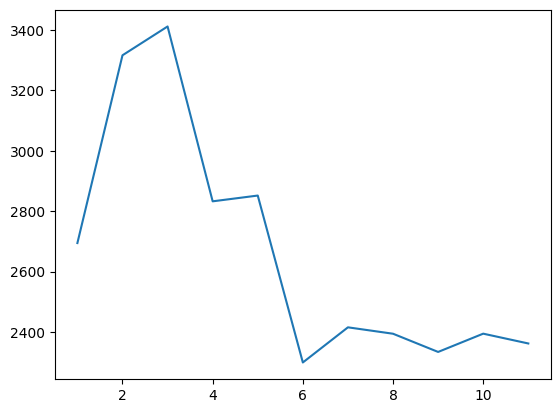

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

### New Model

Vamos a definir otro modelo y el que mejor performance tenga, será el elegido para generar las predicciones.

In [ ]:
new_model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
new_model.add(Embedding(input_dim=vocab_size+1, output_dim=100, input_shape=(None,)))

new_model.add(LSTM(100, return_sequences=True))
new_model.add(Dropout(0.2))

new_model.add(LSTM(100, return_sequences=True))
new_model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
new_model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
new_model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

new_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, None, 100)           │         327,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, None, 100)           │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, None, 100)           │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 32)            │           3,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, None, 3274)          │         108,042 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 599,474 (2.29 MB)

 Trainable params: 599,474 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_ppl = []
hist_2 = new_model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

Epoch 1/20
618/619 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 3.3412
 mean perplexity: 2737.721010462194 

Saved new model!
619/619 ━━━━━━━━━━━━━━━━━━━━ 62s 100ms/step - loss: 3.3411
Epoch 2/20
618/619 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 3.2016
 mean perplexity: 2675.1448736775633 

Saved new model!
619/619 ━━━━━━━━━━━━━━━━━━━━ 77s 92ms/step - loss: 3.2015
Epoch 3/20
618/619 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 3.0971
 mean perplexity: 2623.6412625971975 

Saved new model!
619/619 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - loss: 3.0971
Epoch 4/20
618/619 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 2.9994
 mean perplexity: 2914.4563013492257 

619/619 ━━━━━━━━━━━━━━━━━━━━ 82s 90ms/step - loss: 2.9994
Epoch 5/20
618/619 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 2.9048
 mean perplexity: 2508.561955900137 

Saved new model!
619/619 ━━━━━━━━━━━━━━━━━━━━ 83s 92ms/step - loss: 2.9047
Epoch 6/20
618/619 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 2.8228
 mean perplexity: 2578.3485817710975 

6

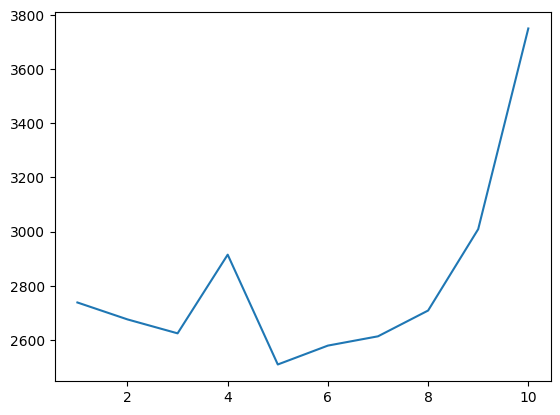

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

En este modelo realizamos algunos cambios: se le agrega una capa densa con 32 neuronas, seguida de una función de activación ReLU aplicada a la salida de esa capa. Se aumentó al doble el output_dim (de 50 a 100) y se agrega dropout.

Los resultados muestran una disminución en la pérdida. Sin embrgo, observamos que la perplejidad, Si bien disminuye al principio, parece aumentar en algunas épocas. Probablemente el modelo esté sobreajustando.

Mejor vamos a hacer una prueba mas, tomando como referencia el primer modelo, agregandole dropOut y aumentando a 75 el output_dim.

### New Model 2

In [ ]:
new_model_2 = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
new_model_2.add(Embedding(input_dim=vocab_size+1, output_dim=75, input_shape=(None,)))

new_model_2.add(LSTM(100, return_sequences=True))
new_model_2.add(Dropout(0.3))

new_model_2.add(LSTM(100, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
new_model_2.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
new_model_2.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

new_model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, None, 75)            │         245,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, None, 100)           │          70,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, None, 100)           │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 3274)          │         330,674 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 727,024 (2.77 MB)

 Trainable params: 727,024 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_ppl = []
hist_3 = new_model_2.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

Epoch 1/20
618/619 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 4.4861
 mean perplexity: 2574.2403649962353 

Saved model 3!
619/619 ━━━━━━━━━━━━━━━━━━━━ 156s 247ms/step - loss: 4.4837
Epoch 2/20
618/619 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 3.4083
 mean perplexity: 2847.2540571160584 

619/619 ━━━━━━━━━━━━━━━━━━━━ 199s 242ms/step - loss: 3.4083
Epoch 3/20
618/619 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 3.3275
 mean perplexity: 4020.245120964199 

619/619 ━━━━━━━━━━━━━━━━━━━━ 200s 239ms/step - loss: 3.3274
Epoch 4/20
618/619 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 3.2243
 mean perplexity: 3199.072062854518 

619/619 ━━━━━━━━━━━━━━━━━━━━ 183s 208ms/step - loss: 3.2242
Epoch 5/20
618/619 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 3.1498
 mean perplexity: 2938.9952870487305 

619/619 ━━━━━━━━━━━━━━━━━━━━ 155s 229ms/step - loss: 3.1497
Epoch 6/20
618/619 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 3.1019
 mean perplexity: 2648.0914067763224 

Stopping training...
619/619 ━━━━━━━━━━

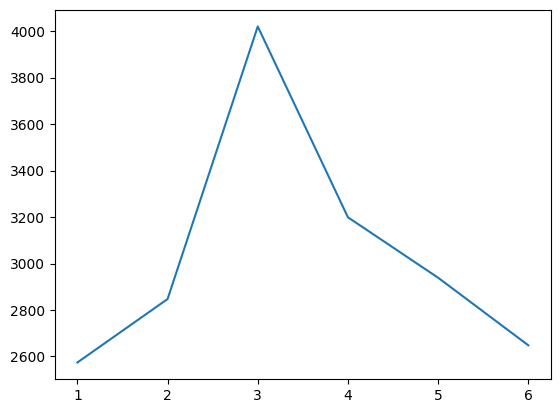

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

El nuevo modelo ha mejorado en comparación con el anterior en cuanto a la perplejidad.

### Carga del mejor modelo

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('model_MJ_3.keras')


### Predicción de próxima palabra

In [ ]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://344462fb7010df980d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://344462fb7010df980d.gradio.live


Al probar el modelo con este generador de palabras se obtiene una predicción pobre en cuanto a que casi siempre predice la palabra "you".

En principio se probó con un par de palabras, luego con una frase de una de las canciones de Michael jackson, el resultado fue el mismo. Pensando que el modelo puede necesitar un mejor contexto se le pasó una parte de una canción de "Billie Jean", donde el resultado fue el mismo: "you".

Cómo observamos que el modelo no ha sobreajustado, estoy se entiende como que el modelo no ha aprendido lo suficiente o tiene un sesgo con esa palabra, ya que es muchas canciones del artista se menciona mucho. Además cuando listamos anteriormente las palabras con las que contamos en el corpus, la palabra "you" es la primera que sale en la lista. Por lo que probablemente sea un sesgo. Vamos a seguir probando!

### Generación de secuencias

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [ ]:
input_text='Dont mind, but\'t'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


"Dont mind, but't you you you you you"

De alguna manera esperábamos este resultado ya que el modelo selecciona la palabra con la mayor probabilidad en cada paso de predicción, lo que tiende a generar resultados repetitivos, mas aún con el sesgo que mencionamos antes.

###  Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [ ]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="For forty days and for forty nights The law was on her side",temp=1,mode='sto')

In [ ]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 14)

In [ ]:
# veamos las salidas
decode(salidas[0])

['forty nights the law was on her side in you you i you name']

Posiblemente, el beam search está explorando opciones que no reflejan bien la semántica, probablemente por la distribución de probabilidades del modelo está dominada por las palabras más comunes.

In [ ]:
salidas = beam_search(model, num_beams=10, num_words=6, input=input_text, temp=0.7, mode='sto')
salidas.shape
decode(salidas[0])

['dont mind me you the i you in']

In [ ]:
salidas = beam_search(model, num_beams=10, num_words=6, input=input_text, temp=3.7, mode='sto')
salidas.shape
decode(salidas[0])

['dont mind on il i lock exhibition afford']

In [ ]:
salidas = beam_search(model, num_beams=10, num_words=6, input=input_text, temp=1.7, mode='sto')
salidas.shape
decode(salidas[0])

["dont mind gonna on you touchin' it only"]

In [ ]:
salidas = beam_search(model, num_beams=10, num_words=6, input=input_text, temp=1.2, mode='sto')
salidas.shape
decode(salidas[0])

['dont mind i off the the that and']

In [ ]:
salidas = beam_search(model, num_beams=10, num_words=6, input=input_text, temp=0.9, mode='sto')
salidas.shape
decode(salidas[0])

['dont mind you you me the out and']

### Conclusion

Se observa que al aumentar demasiado la temperatura el modelo predice palabras menos esperadas pero a la vez mas incoherentes. Es interesante ver como a medida que cambiamos la temperatura la salida cambia desde una salida muy conservadora en temperaturas mas bajas (lo que en este caso a veces se vuelve repetitivo) a una salida mas creativa, diversa y cada vez mas incoherente en temperaturas muy altas.